# Application of Gaussian Process Regression to vertical profiles of the atmosphere

## Imports

In [1]:
# general imports
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tqdm
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import gruanpy as gp

## Data

In [2]:
# data
path = r'C:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\gdp\icm16\LIN-RS-01_2_RS41-GDP_001_20170303T120000_1-004-002.nc'
gdp = gp.read(path)
start = gdp.data['time'].values[0]
data=gdp.data[100:400]
time = data['time'].values
seconds = (time - start) / np.timedelta64(1, 's')
seconds = seconds.astype(float)

temp = data['temp'].values
temp_uc = data['temp_uc'].values
temp_variance = (temp_uc / 2)**2
alt = data['alt'].values
alt_uc = data['alt_uc'].values
alt_variance = (alt_uc / 2)**2
rh = data['rh'].values
rh_uc = data['rh_uc'].values
rh_variance = (rh_uc / 2)**2
press = data['press'].values
press_uc = data['press_uc'].values
press_variance = (press_uc / 2)**2
wspeed = data['wspeed'].values
wspeed_uc = data['wspeed_uc'].values
wspeed_variance = (wspeed_uc / 2)**2
wdir = data['wdir'].values
wdir_uc = data['wdir_uc'].values
wdir_variance = (wdir_uc / 2)**2

In [39]:
train_mask = range(0, len(seconds), 2)
test_mask = range(1, len(seconds)-2, 1)
train_seconds = seconds[train_mask]
train_temp = temp[train_mask]
train_temp_variance = temp_variance[train_mask]
train_temp_uc = temp_uc[train_mask]
test_seconds = seconds[test_mask]
test_temp = temp[test_mask]
test_temp_variance = temp_variance[test_mask]
test_temp_uc = temp_uc[test_mask]
train_rh = rh[train_mask]
train_rh_variance = rh_variance[train_mask]
train_rh_uc = rh_uc[train_mask]
test_rh = rh[test_mask]
test_rh_variance = rh_variance[test_mask]
test_rh_uc = rh_uc[test_mask]
train_press = press[train_mask]
train_press_variance = press_variance[train_mask]
train_press_uc = press_uc[train_mask]
test_press = press[test_mask]
test_press_variance = press_variance[test_mask]
test_press_uc = press_uc[test_mask]
train_wspeed = wspeed[train_mask]
train_wspeed_variance = wspeed_variance[train_mask]
train_wspeed_uc = wspeed_uc[train_mask]
test_wspeed = wspeed[test_mask]
test_wspeed_variance = wspeed_variance[test_mask]
test_wspeed_uc = wspeed_uc[test_mask]
train_wdir = wdir[train_mask]
train_wdir_variance = wdir_variance[train_mask]
train_wdir_uc = wdir_uc[train_mask]
test_wdir = wdir[test_mask]
test_wdir_variance = wdir_variance[test_mask]
test_wdir_uc = wdir_uc[test_mask]
train_alt = alt[train_mask]
train_alt_variance = alt_variance[train_mask]
train_alt_uc = alt_uc[train_mask]
test_alt = alt[test_mask]
test_alt_variance = alt_variance[test_mask]
test_alt_uc = alt_uc[test_mask]


In [49]:
def points_plot(observed_x, observed_y, observed_uc, test_x, test_y, test_yuc, title, xlabel, ylabel,
                simulations=False):
    plt.figure(figsize=(10, 6))
    if observed_x is not None:
        plt.errorbar(observed_x, observed_y, yerr=observed_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
    if test_x is not None and test_y is not None:
        plt.errorbar(test_x, test_y, yerr=test_yuc, fmt='.', alpha=0.5, label='Predictions', color='#ff7f0e')
    if simulations:
        colors = ['#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', "#144a46"]
        for i, sim in enumerate(simulations):
            plt.scatter(test_x, sim, alpha=0.5, color=colors[i % len(colors)], label=f'Simulation {i+1}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.show()

def interpolated_plot(observed_x, observed_y, observed_uc, test_x, test_y_mean, test_yuc, title, xlabel, ylabel
                      ,simulations=False):
    plt.figure(figsize=(10, 6))
    if observed_x is not None:
        plt.plot(observed_x, observed_y, label='Observations', alpha=0.5, color='#1f77b4')
        plt.fill_between(observed_x, observed_y - observed_uc, observed_y + observed_uc, alpha=0.5, label='Uncertainty', color='#1f77b4')
    if test_x is not None and test_y_mean is not None:
        plt.plot(test_x, test_y_mean, label='Mean Prediction', color='#ff7f0e')
        plt.fill_between(test_x, test_y_mean - 2*test_yuc, test_y_mean + 2*test_yuc, alpha=0.3, label='Confidence Interval', color='#ff7f0e')
        plt.xlabel(xlabel)
    if simulations:
        colors = ['#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', "#144a46"]
        for i, sim in enumerate(simulations):
            plt.plot(test_x, sim, alpha=0.5, color=colors[i % len(colors)], label=f'Simulation {i+1}')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.show()


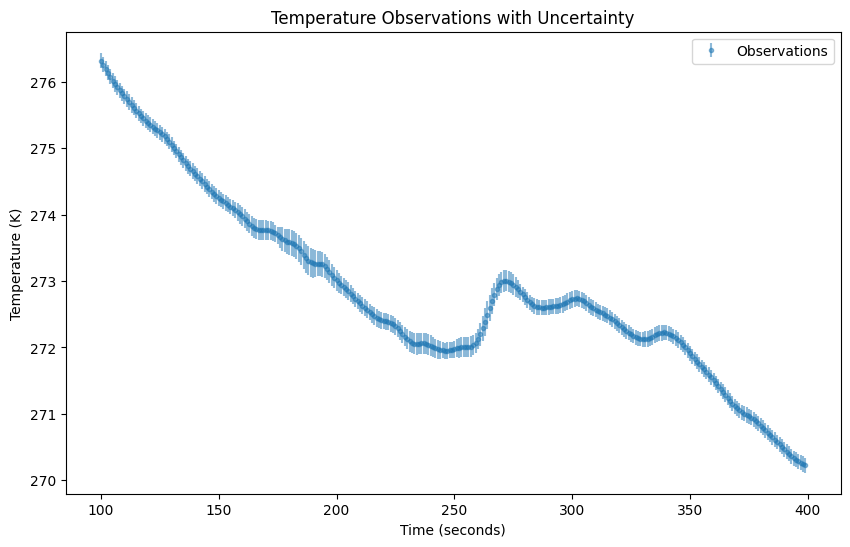

In [22]:
points_plot(seconds, temp, temp_uc, None, None, None, 'Temperature Observations with Uncertainty', 'Time (seconds)', 'Temperature (K)')

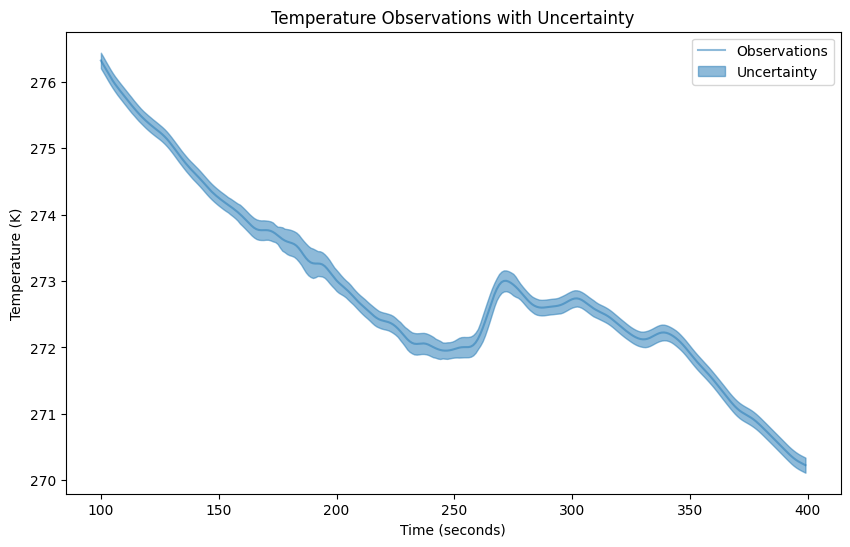

In [23]:
interpolated_plot(seconds, temp, temp_uc, None, None, None, 'Temperature Observations with Uncertainty', 'Time (seconds)', 'Temperature (K)')

# GP Regression from Scratch

Ispiration from: https://github.com/peterroelants/peterroelants.github.io/tree/main/notebooks/gaussian_process

In [24]:
# kernel function
def exponential_kernel(x1, x2, length_scale, variance):
    """Exponential kernel function."""
    dists = np.abs(x1[:, None] - x2[None, :])
    return variance * np.exp(-dists / length_scale)

In [25]:
# a priori sampling
length_scale = 50.0  # length scale of the kernel
variance = 1.0       # variance of the kernel
K = exponential_kernel(seconds, seconds, length_scale, variance)
prior = K @ np.random.normal(size=(len(seconds), 3))

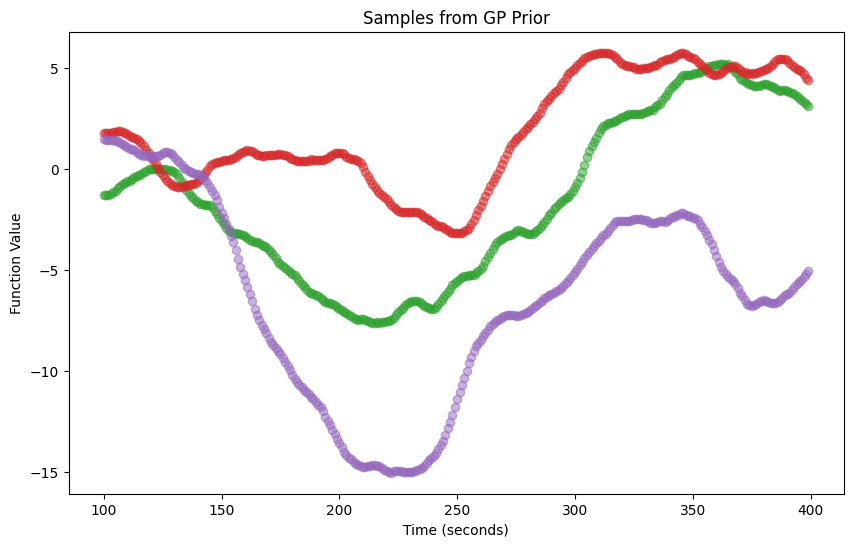

In [26]:
simulations = []
for i in range(prior.shape[1]):
    simulations.append(prior[:, i])
points_plot(None, None, None, seconds, None, None, 'Samples from GP Prior', 'Time (seconds)', 'Function Value', simulations=simulations)

C:\Users\tomma\AppData\Local\Temp\ipykernel_17744\2032191890.py:28: RuntimeWarning: invalid value encountered in sqrt
  std_post = np.sqrt(np.diag(cov_post))


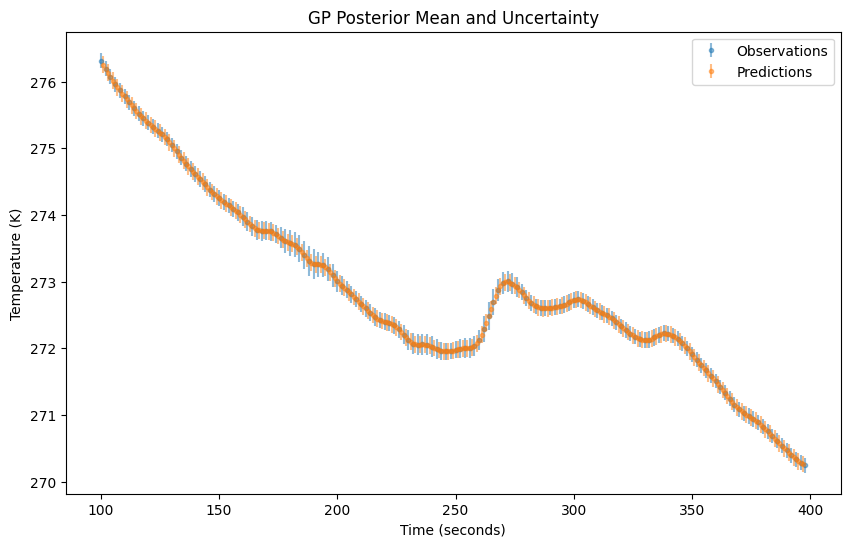

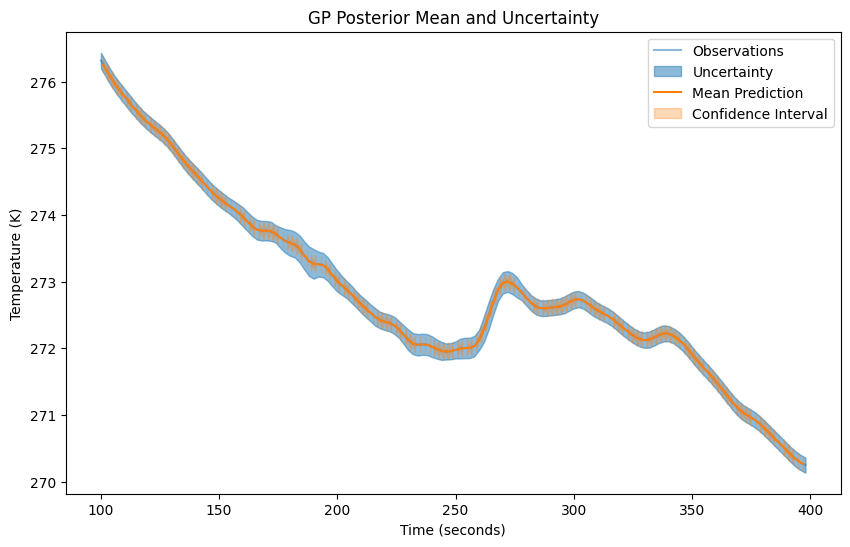

In [27]:
# posterior distribution

def posterior_sampling(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

mu_post, cov_post = posterior_sampling(
    train_seconds,
    train_temp,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)
std_post = np.sqrt(np.diag(cov_post))
# plot mu_post and uncertainty
points_plot(train_seconds, train_temp, train_temp_uc, test_seconds, mu_post, 2*std_post,
            'GP Posterior Mean and Uncertainty', 'Time (seconds)', 'Temperature (K)')
interpolated_plot(train_seconds, train_temp, train_temp_uc, test_seconds, mu_post, std_post,
                  'GP Posterior Mean and Uncertainty', 'Time (seconds)', 'Temperature (K)')

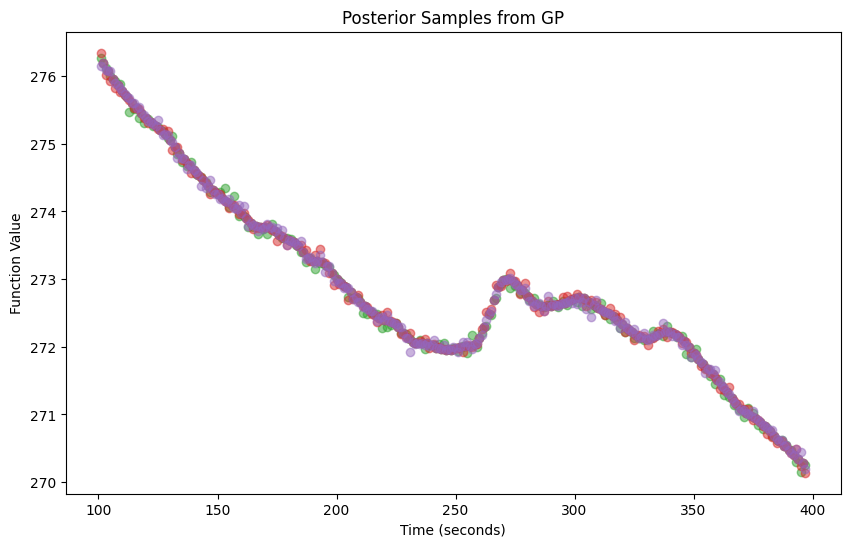

In [28]:
# posterior sampling
# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=mu_post, cov=cov_post, size=3)
simulations = []
for i in range(y2.shape[0]):
    simulations.append(y2[i, :])
points_plot(None, None, None, test_seconds, None, None, 'Posterior Samples from GP', 'Time (seconds)', 'Function Value', simulations=simulations)

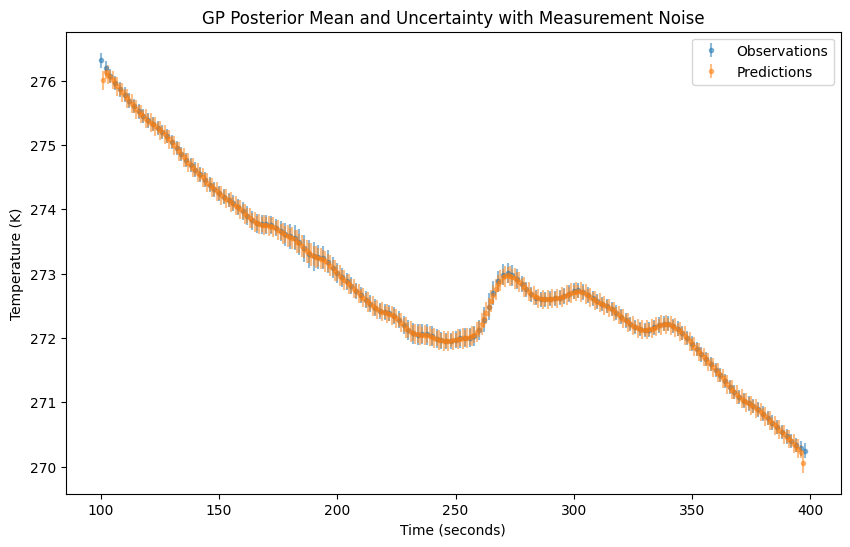

In [29]:
# add measurement error to posterior covariance

def posterior_sampling_with_noise(X1, y1, var1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    observation variances var1, and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1) + np.diag(var1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    train_seconds,
    train_temp,
    train_temp_variance,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
points_plot(train_seconds, train_temp, train_temp_uc, test_seconds, mu_post_noise, 2*std_post_noise,
            'GP Posterior Mean and Uncertainty with Measurement Noise', 'Time (seconds)', 'Temperature (K)')

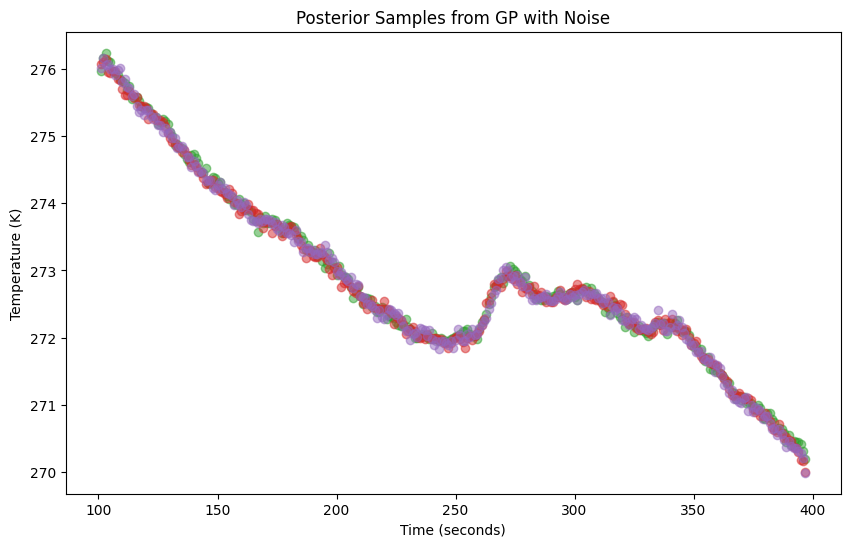

In [30]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
simulations = []
for i in range(y2_noise.shape[0]):
    simulations.append(y2_noise[i, :])
points_plot(None, None, None, test_seconds, None, None, 'Posterior Samples from GP with Noise', 'Time (seconds)', 'Temperature (K)', simulations=simulations)

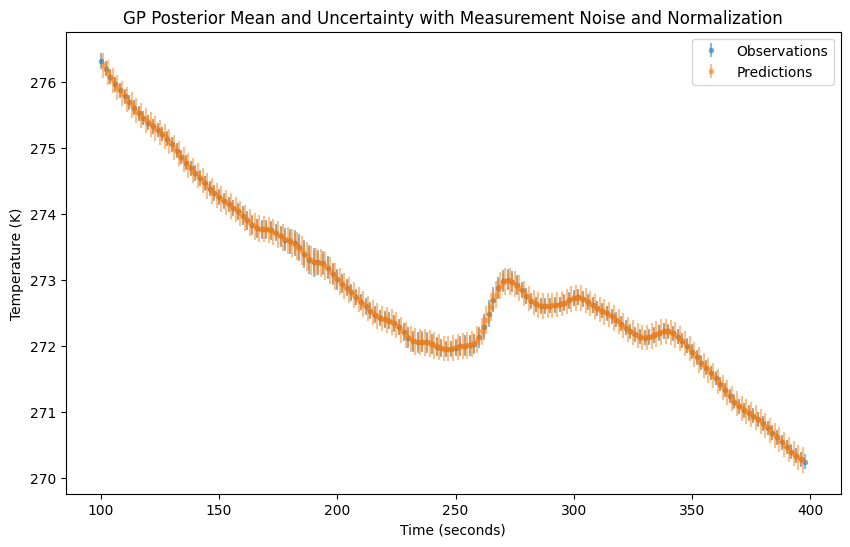

In [31]:
# gp with measurement error and normalized data

avg_temp = np.mean(train_temp)
var_temp = np.var(train_temp)
norm_train_temp = (train_temp - avg_temp) / np.sqrt(var_temp)
norm_train_variance = train_temp_variance / var_temp

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    train_seconds,
    norm_train_temp,
    norm_train_variance,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)
mu_post_noise = mu_post_noise * np.sqrt(var_temp) + avg_temp
cov_post_noise = cov_post_noise * var_temp
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
points_plot(train_seconds, train_temp, train_temp_uc, test_seconds, mu_post_noise, 2*std_post_noise,
            'GP Posterior Mean and Uncertainty with Measurement Noise and Normalization', 'Time (seconds)', 'Temperature (K)')

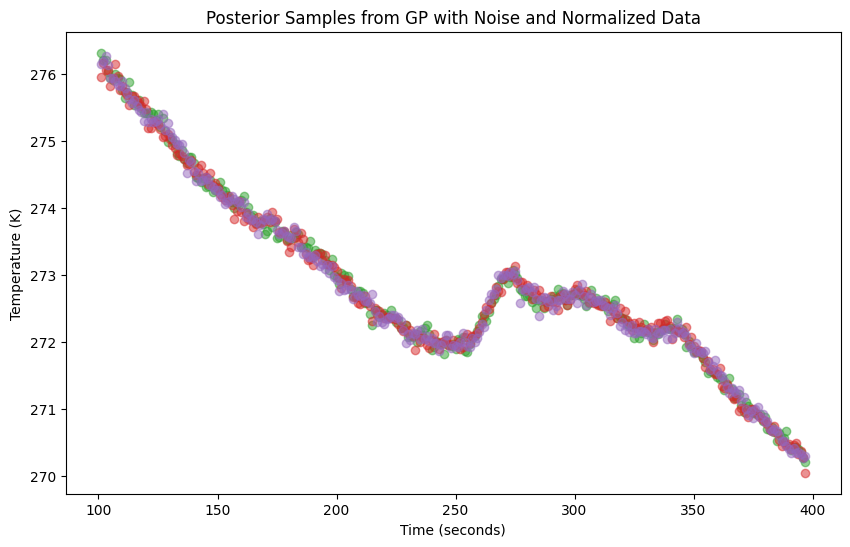

In [32]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
# plot posterior samples with noise
simulations = []
for i in range(y2_noise.shape[0]):
    simulations.append(y2_noise[i, :])
points_plot(None, None, None, test_seconds, None, None, 'Posterior Samples from GP with Noise and Normalized Data', 'Time (seconds)', 'Temperature (K)', simulations=simulations)

# Sklearn GaussianProcessRegressor

In [33]:
# more imports
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.linear_model import LinearRegression

Gaussian process regression (GPR)

**kernel:**

The kernel specifying the covariance function of the GP.

**alpha:**

Value added to the diagonal of the kernel matrix during fitting.
This can prevent a potential numerical issue during fitting, by
ensuring that the calculated values form a positive definite matrix.
It can also be interpreted as the variance of additional Gaussian
measurement noise on the training observations. Note that this is
different from using a `WhiteKernel`. If an array is passed, it must have the same number of entries as the data used for fitting and is used as datapoint-dependent noise level.

**optimizer:**

Can either be one of the internally supported optimizers for optimizing the kernel's parameters, specified by a string, or an externally defined optimizer passed as a callable. 
If None is passed, the kernel's parameters are kept fixed. Per default, the L-BFGS-B algorithm.

**n_restarts_optimizer:**

The number of restarts of the optimizer for finding the kernel's
parameters which maximize the **log-marginal likelihood**. The first run of the optimizer is performed from the kernel's initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. Note that `n_restarts_optimizer == 0` implies that one run is performed.

**normalize_y:**

Whether or not to normalize the target values `y` by removing the mean and scaling to unit-variance. This is recommended for cases where zero-mean, unit-variance priors are used. Note that, in this implementation, the normalisation is reversed before the GP predictions are reported.

**copy_X_train:**

If True, a persistent copy of the training data is stored in the
object. Otherwise, just a reference to the training data is stored,
which might cause predictions to change if the data is modified
externally.

**random_state:**

Determines random number generation used to initialize the centers.
Pass an int for reproducible results across multiple function calls.


In [48]:
simulations[0].shape

(297,)

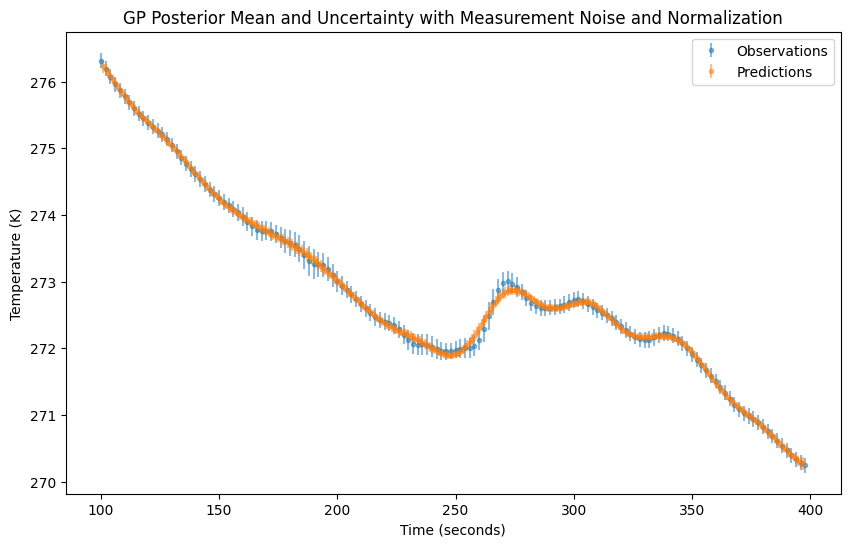

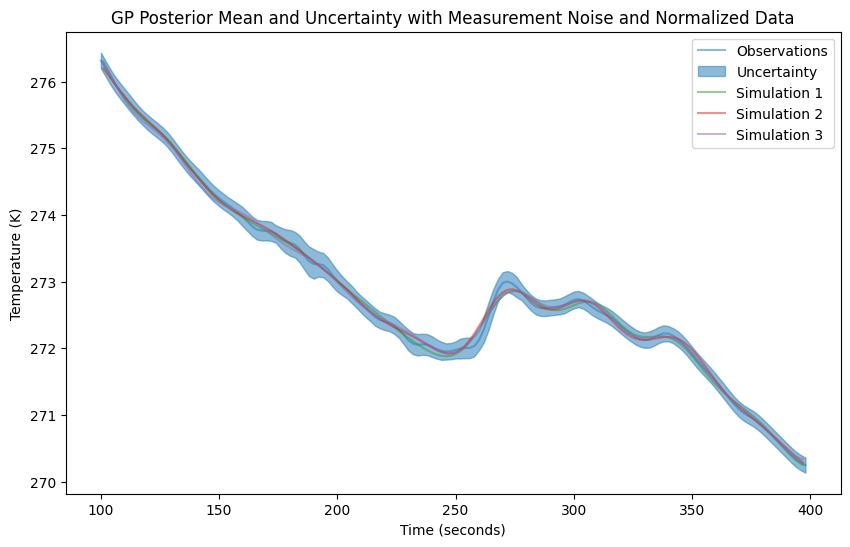

   length_scale length_scale_bounds
0     19.904422   (1e-05, 100000.0)
Log-Marginal-Likelihood: 186.73654940467915


In [50]:
# gp using sklearn with measurement error and normalized data
X = train_seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=train_temp_variance,
    normalize_y=True)
# Fit and plot
gp_model.fit(X, train_temp)
y_pred, y_std = gp_model.predict(test_seconds.reshape(-1, 1), return_std=True)
points_plot(train_seconds, train_temp, train_temp_uc, test_seconds, y_pred, y_std*2,
            'GP Posterior Mean and Uncertainty with Measurement Noise and Normalization', 'Time (seconds)', 'Temperature (K)')
y_samples = gp_model.sample_y(test_seconds.reshape(-1, 1), n_samples=3, random_state=42)
simulations = []
for i in range(y_samples.shape[1]):
    simulations.append(y_samples[:, i])
interpolated_plot(train_seconds, train_temp, train_temp_uc, test_seconds, None, None,
                  'GP Posterior Mean and Uncertainty with Measurement Noise and Normalized Data', 'Time (seconds)', 'Temperature (K)', simulations=simulations)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

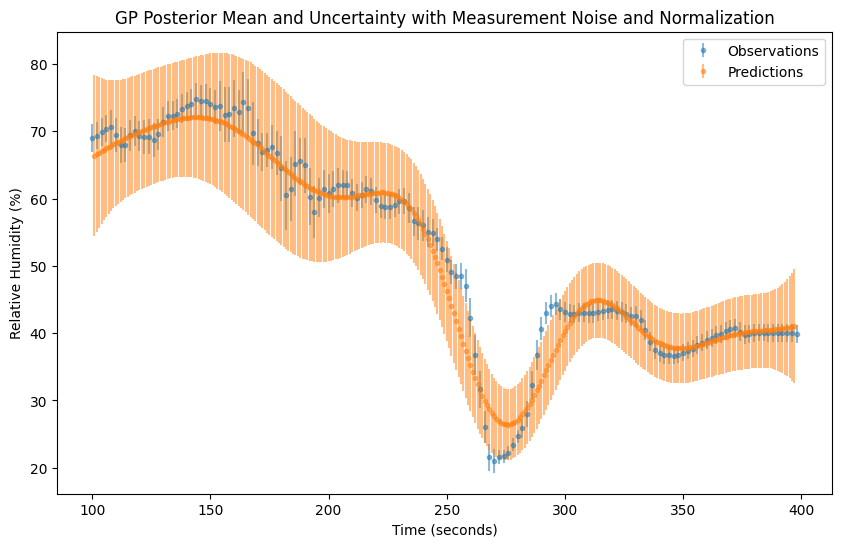

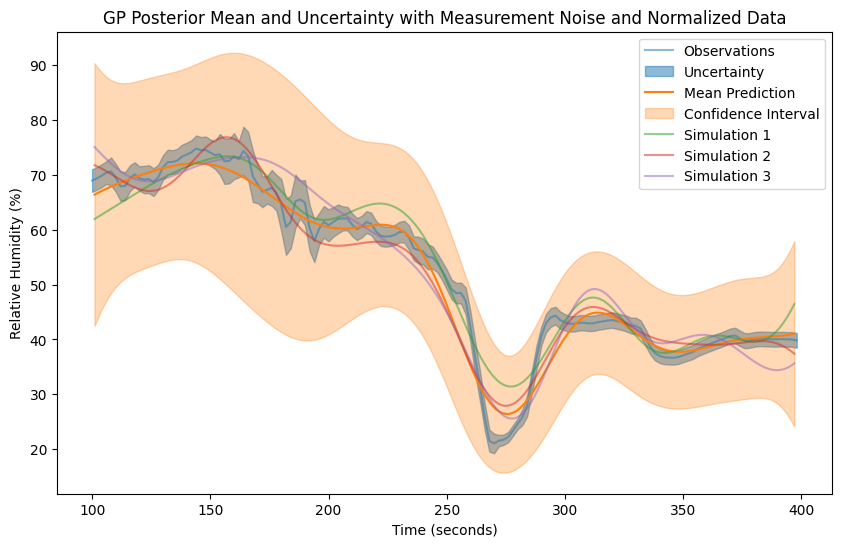

   length_scale length_scale_bounds
0     26.384191   (1e-05, 100000.0)
Log-Marginal-Likelihood: -155.99559245364094


In [52]:
# gp using sklearn with measurement error and normalized data
X = train_seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=train_rh_variance,
    normalize_y=True)
# Fit and plot
gp_model.fit(X, train_rh)
y_pred, y_std = gp_model.predict(test_seconds.reshape(-1, 1), return_std=True)
points_plot(train_seconds, train_rh, train_rh_uc, test_seconds, y_pred, y_std*2,
            'GP Posterior Mean and Uncertainty with Measurement Noise and Normalization', 'Time (seconds)', 'Relative Humidity (%)')
y_samples = gp_model.sample_y(test_seconds.reshape(-1, 1), n_samples=3, random_state=42)
simulations = []
for i in range(y_samples.shape[1]):
    simulations.append(y_samples[:, i])
interpolated_plot(train_seconds, train_rh, train_rh_uc, test_seconds, y_pred, y_std*2,
                  'GP Posterior Mean and Uncertainty with Measurement Noise and Normalized Data', 'Time (seconds)', 'Relative Humidity (%)', simulations=simulations)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

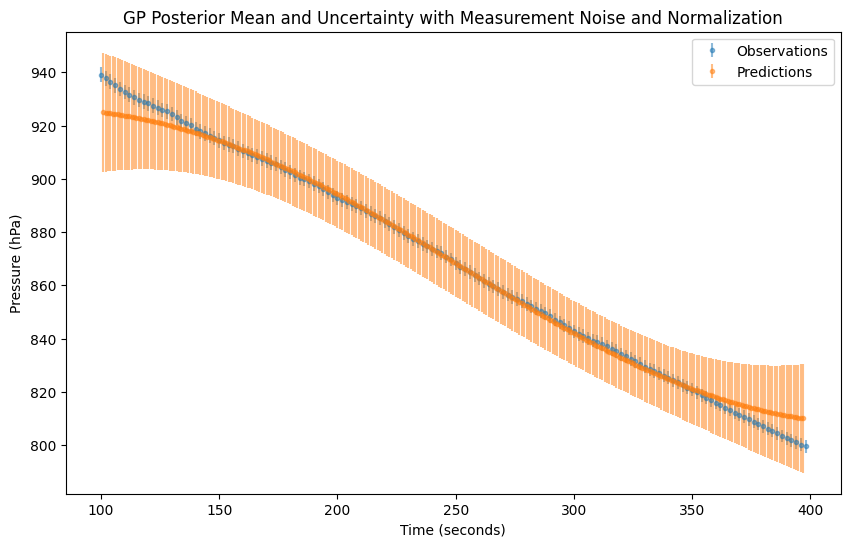

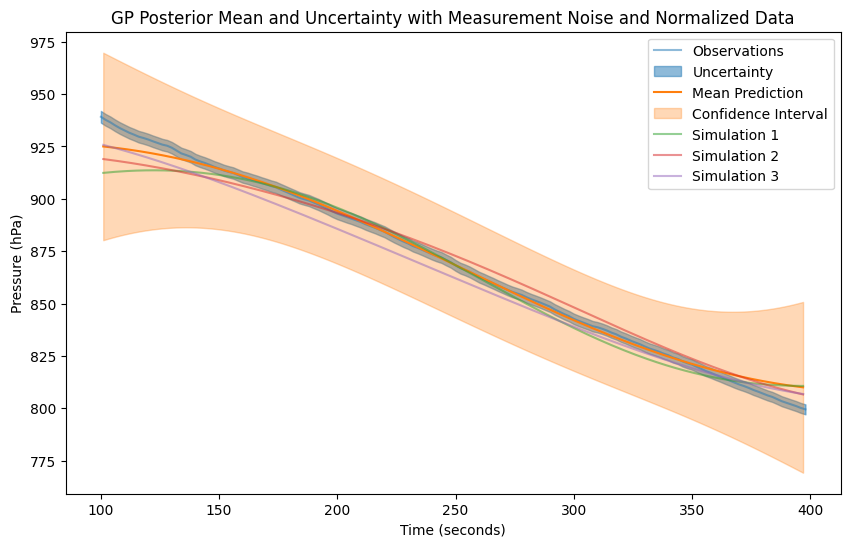

   length_scale length_scale_bounds
0    154.703265   (1e-05, 100000.0)
Log-Marginal-Likelihood: -183.01347209234513


In [53]:
# gp using sklearn with measurement error and normalized data
X = train_seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=train_press_variance,
    normalize_y=True)
# Fit and plot
gp_model.fit(X, train_press)
y_pred, y_std = gp_model.predict(test_seconds.reshape(-1, 1), return_std=True)
points_plot(train_seconds, train_press, train_press_uc, test_seconds, y_pred, y_std*2,
            'GP Posterior Mean and Uncertainty with Measurement Noise and Normalization', 'Time (seconds)', 'Pressure (hPa)')
y_samples = gp_model.sample_y(test_seconds.reshape(-1, 1), n_samples=3, random_state=42)
simulations = []
for i in range(y_samples.shape[1]):
    simulations.append(y_samples[:, i])
interpolated_plot(train_seconds, train_press, train_press_uc, test_seconds, y_pred, y_std*2,
                  'GP Posterior Mean and Uncertainty with Measurement Noise and Normalized Data', 'Time (seconds)', 'Pressure (hPa)', simulations=simulations)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

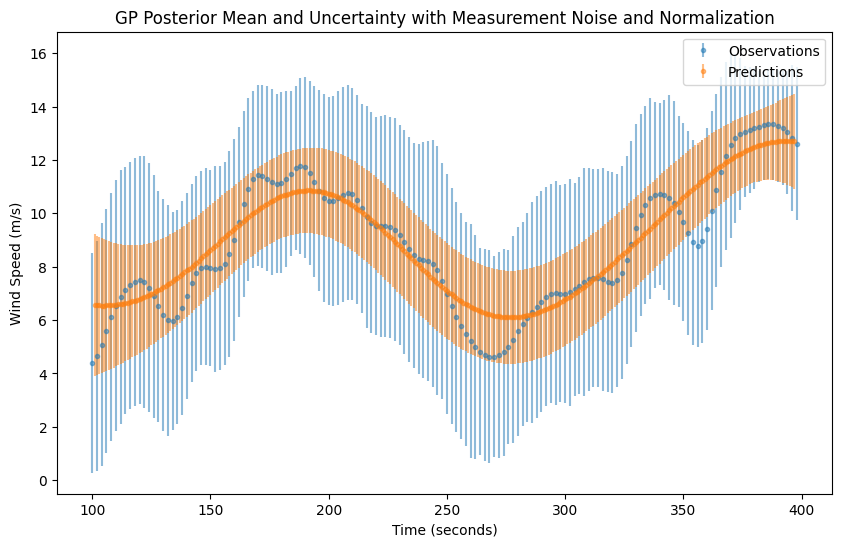

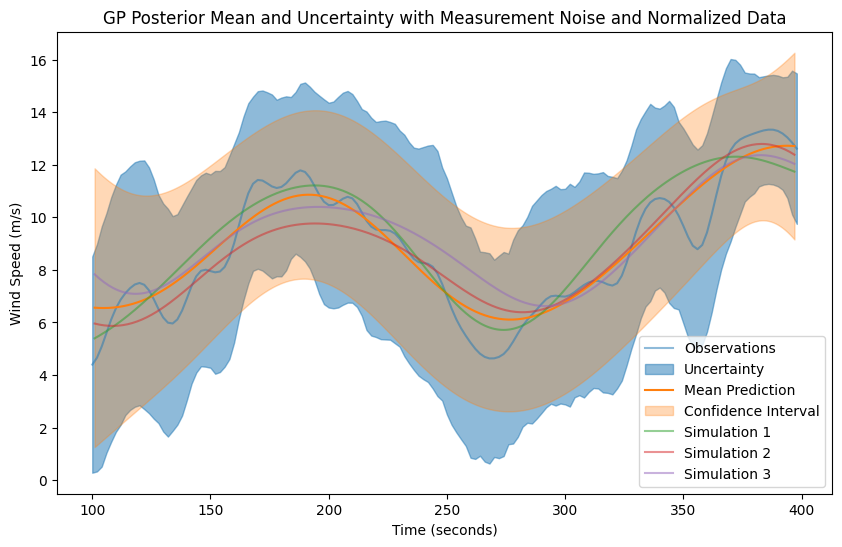

   length_scale length_scale_bounds
0     42.905477   (1e-05, 100000.0)
Log-Marginal-Likelihood: -244.82568312280875


In [55]:
# gp using sklearn with measurement error and normalized data
X = train_seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=train_wspeed_variance,
    normalize_y=True)
# Fit and plot
gp_model.fit(X, train_wspeed)
y_pred, y_std = gp_model.predict(test_seconds.reshape(-1, 1), return_std=True)
points_plot(train_seconds, train_wspeed, train_wspeed_uc, test_seconds, y_pred, y_std*2,
            'GP Posterior Mean and Uncertainty with Measurement Noise and Normalization', 'Time (seconds)', 'Wind Speed (m/s)')
y_samples = gp_model.sample_y(test_seconds.reshape(-1, 1), n_samples=3, random_state=42)
simulations = []
for i in range(y_samples.shape[1]):
    simulations.append(y_samples[:, i])
interpolated_plot(train_seconds, train_wspeed, train_wspeed_uc, test_seconds, y_pred, y_std*2,
                  'GP Posterior Mean and Uncertainty with Measurement Noise and Normalized Data', 'Time (seconds)', 'Wind Speed (m/s)', simulations=simulations)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

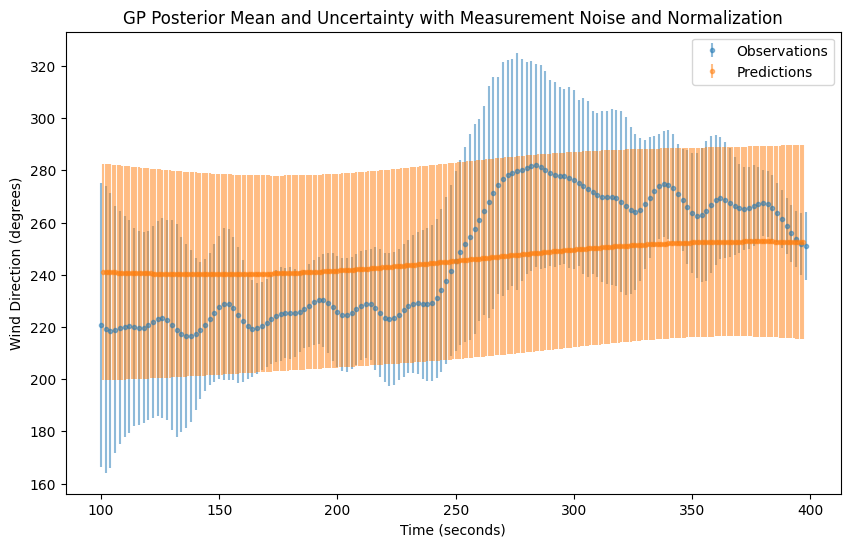

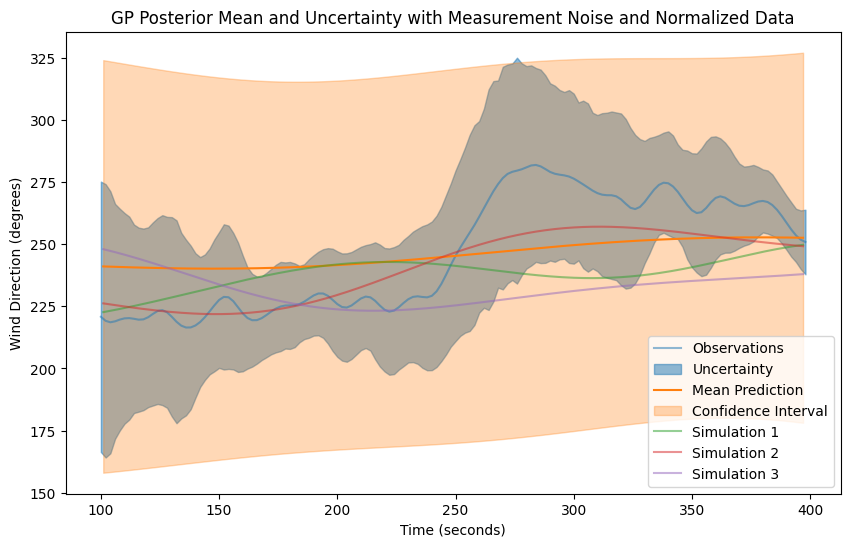

   length_scale length_scale_bounds
0     96.074859   (1e-05, 100000.0)
Log-Marginal-Likelihood: -524.2520569201564


In [56]:
# gp using sklearn with measurement error and normalized data
X = train_seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=train_wdir_variance,
    normalize_y=True)
# Fit and plot
gp_model.fit(X, train_wdir)
y_pred, y_std = gp_model.predict(test_seconds.reshape(-1, 1), return_std=True)
points_plot(train_seconds, train_wdir, train_wdir_uc, test_seconds, y_pred, y_std*2,
            'GP Posterior Mean and Uncertainty with Measurement Noise and Normalization', 'Time (seconds)', 'Wind Direction (degrees)')
y_samples = gp_model.sample_y(test_seconds.reshape(-1, 1), n_samples=3, random_state=42)
simulations = []
for i in range(y_samples.shape[1]):
    simulations.append(y_samples[:, i])
interpolated_plot(train_seconds, train_wdir, train_wdir_uc, test_seconds, y_pred, y_std*2,
                  'GP Posterior Mean and Uncertainty with Measurement Noise and Normalized Data', 'Time (seconds)', 'Wind Direction (degrees)', simulations=simulations)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

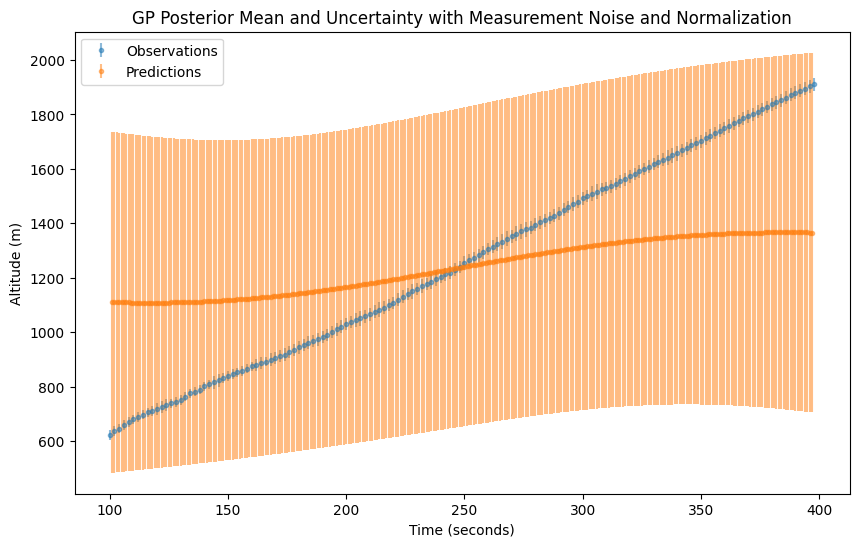

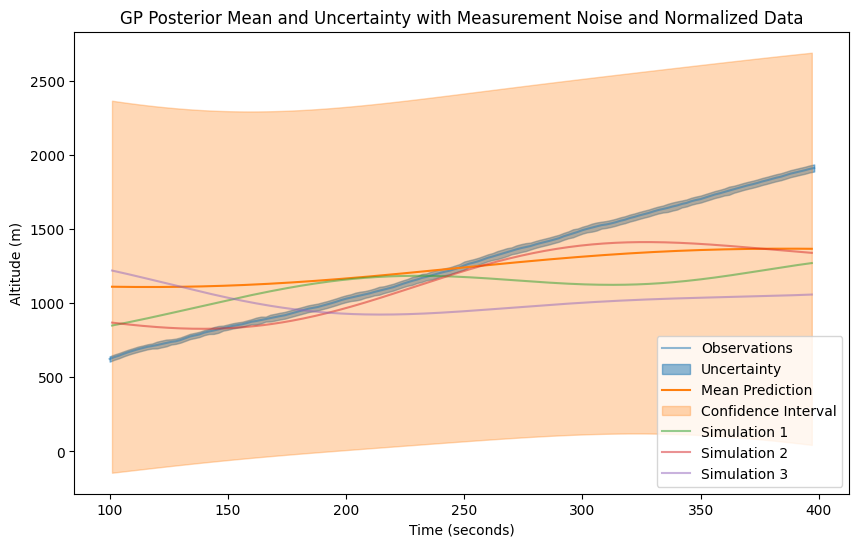

   length_scale length_scale_bounds
0    109.957662   (1e-05, 100000.0)
Log-Marginal-Likelihood: -502.0618206486274


In [57]:
# gp using sklearn with measurement error and normalized data
X = train_seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=train_alt_variance,
    normalize_y=True)
# Fit and plot
gp_model.fit(X, train_alt)
y_pred, y_std = gp_model.predict(test_seconds.reshape(-1, 1), return_std=True)
points_plot(train_seconds, train_alt, train_alt_uc, test_seconds, y_pred, y_std*2,
            'GP Posterior Mean and Uncertainty with Measurement Noise and Normalization', 'Time (seconds)', 'Altitude (m)')
y_samples = gp_model.sample_y(test_seconds.reshape(-1, 1), n_samples=3, random_state=42)
simulations = []
for i in range(y_samples.shape[1]):
    simulations.append(y_samples[:, i])
interpolated_plot(train_seconds, train_alt, train_alt_uc, test_seconds, y_pred, y_std*2,
                  'GP Posterior Mean and Uncertainty with Measurement Noise and Normalized Data', 'Time (seconds)', 'Altitude (m)', simulations=simulations)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

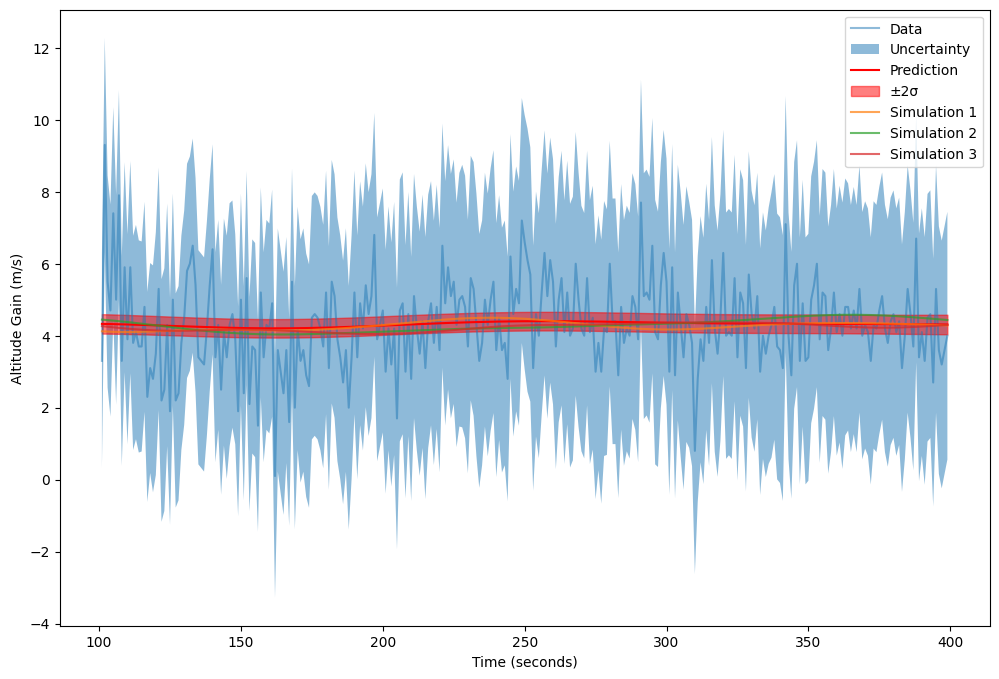

In [34]:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds[1:].reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()*ConstantKernel()

alt_gain = np.array([alt[i] - alt[i-1] for i in range(1, len(alt))])
alt_gain_uc = np.array([np.sqrt(alt_uc[i]*0.5**2 + alt_uc[i-1]*0.5**2) for i in range(1, len(alt_uc))])
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=alt_gain_uc, 
    # try with or without aplha parameter moves the uncertainty from noise to correlation (optimal lenghtscale gets very little without alpha and very large with alpha)
    normalize_y=True)

# Fit to data
gp_model.fit(X, alt_gain)
# Predict
X_pred = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred, y_std = gp_model.predict(X_pred, return_std=True)
# Plot results
plt.figure(figsize=(12, 8))
plt.plot(seconds[1:], alt_gain, label='Data', alpha=0.5)
plt.fill_between(seconds[1:], alt_gain - alt_gain_uc, alt_gain + alt_gain_uc, alpha=0.5, label='Uncertainty')

# Plot prediction
plt.plot(X_pred, y_pred, label='Prediction', color='red')
plt.fill_between(X_pred.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='red', label='±2σ')

# Sample 3 simulations from the GP
y_samples = gp_model.sample_y(X_pred, n_samples=3, random_state=42)

# Plot simulations
for i in range(3):
    plt.plot(X_pred, y_samples[:, i], alpha=0.7, label=f'Simulation {i+1}')

plt.xlabel('Time (seconds)')
plt.ylabel('Altitude Gain (m/s)')
plt.legend()
plt.show()


coef: [4.35515925] intercept: 174.82296024496873
   length_scale length_scale_bounds
0      1.150504   (1e-05, 100000.0)
Log-Marginal-Likelihood: -9620.779807365481


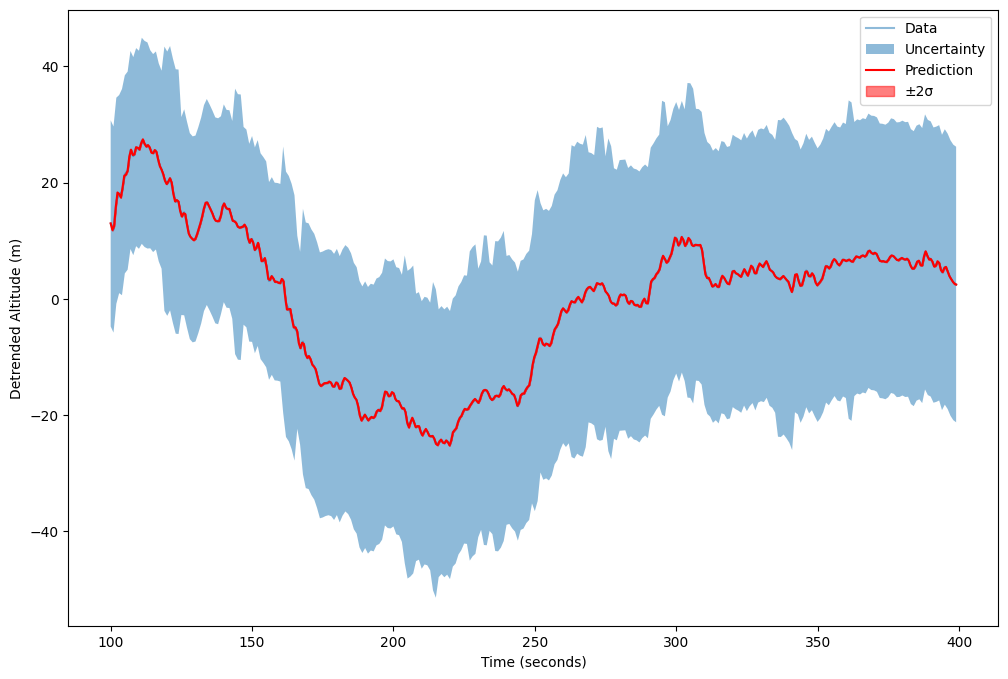

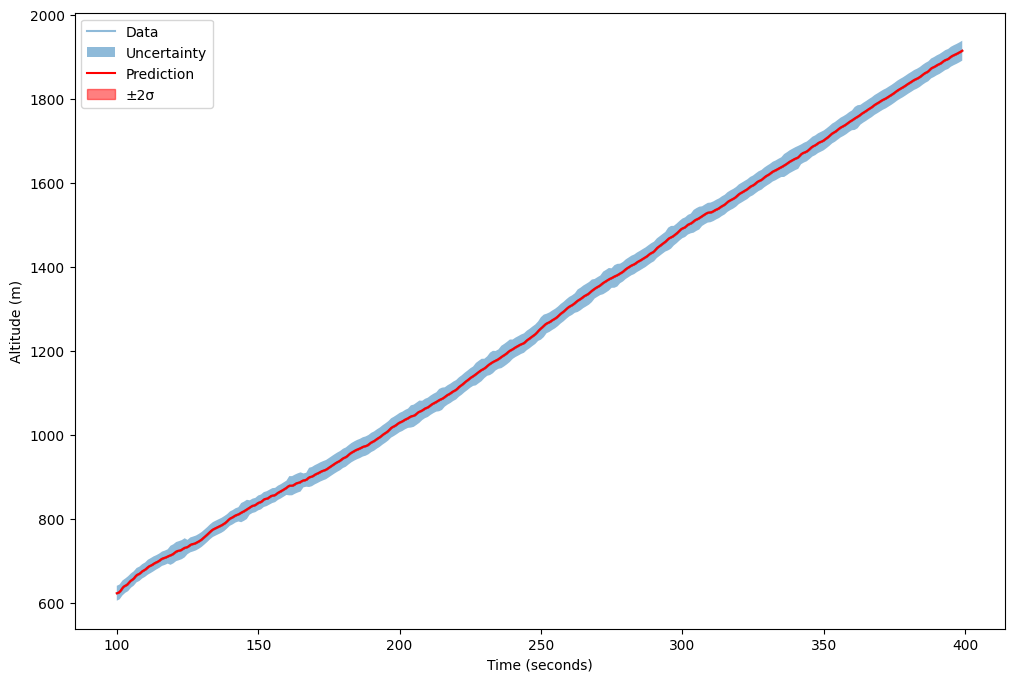

In [22]:
from sklearn.linear_model import LinearRegression

# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
kernel = RBF()

lin_model = LinearRegression()
lin_model.fit(seconds.reshape(-1, 1), alt)
print("coef:", lin_model.coef_, "intercept:", lin_model.intercept_)
alt_trend = lin_model.predict(seconds.reshape(-1, 1))
alt_detrended = alt - alt_trend
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    #alpha=alt_variance,
    normalize_y=False)
# Fit and plot
gp_model.fit(X, alt_detrended)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")
X_pred = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
alt_detrended_pred, alt_detrended_std = gp_model.predict(X_pred, return_std=True)
alt_pred = alt_detrended_pred + lin_model.predict(X_pred)
alt
# plot detrended result
plt.figure(figsize=(12, 8))
plt.plot(seconds, alt_detrended, label='Data', alpha=0.5)
plt.fill_between(seconds, alt_detrended - alt_uc, alt_detrended + alt_uc, alpha=0.5, label='Uncertainty')
plt.plot(X_pred, alt_detrended_pred, label='Prediction', color='red')
plt.fill_between(X_pred.ravel(), alt_detrended_pred - 2*alt_detrended_std, alt_detrended_pred + 2*alt_detrended_std, alpha=0.5, color='red', label='±2σ')
plt.xlabel('Time (seconds)')
plt.ylabel('Detrended Altitude (m)')
plt.legend()
plt.show()

# plot final result
plt.figure(figsize=(12, 8))
plt.plot(seconds, alt, label='Data', alpha=0.5)
plt.fill_between(seconds, alt - alt_uc, alt + alt_uc, alpha=0.5, label='Uncertainty')
plt.plot(X_pred, alt_pred, label='Prediction', color='red')
plt.fill_between(X_pred.ravel(), alt_pred - 2*alt_detrended_std, alt_pred + 2*alt_detrended_std, alpha=0.5, color='red', label='±2σ')
plt.xlabel('Time (seconds)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.show()

coef: [4.35515925] intercept: 174.82296024496873
                       k1       k2  k1__length_scale k1__length_scale_bounds  \
0  RBF(length_scale=34.4)  1.73**2         34.385035       (1e-05, 100000.0)   

   k2__constant_value k2__constant_value_bounds  
0            3.006195         (1e-05, 100000.0)  
Log-Marginal-Likelihood: -1161.2866944410307


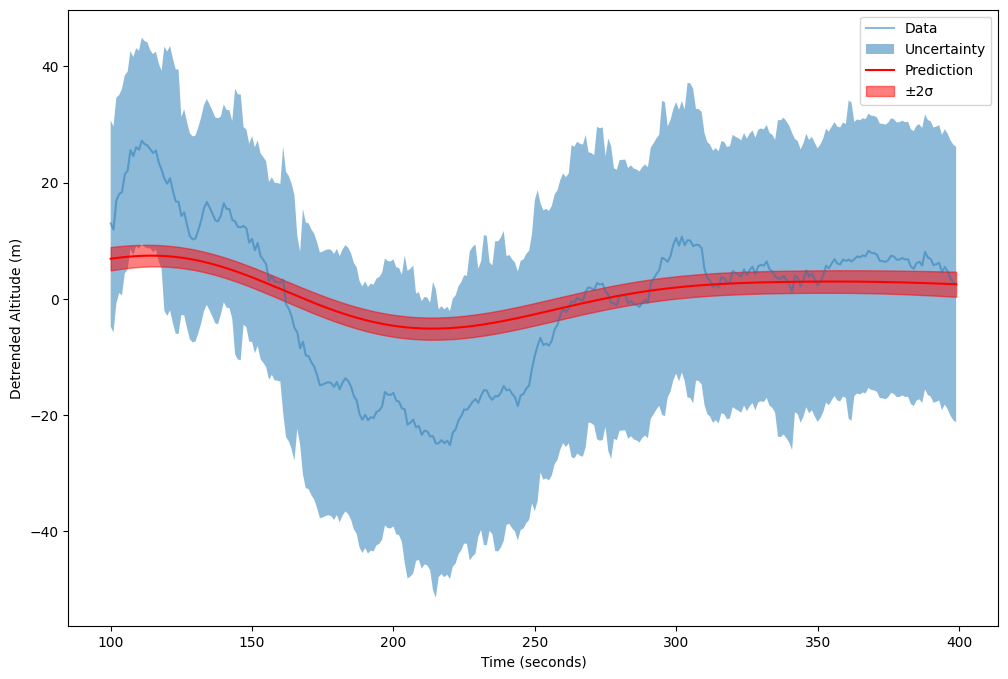

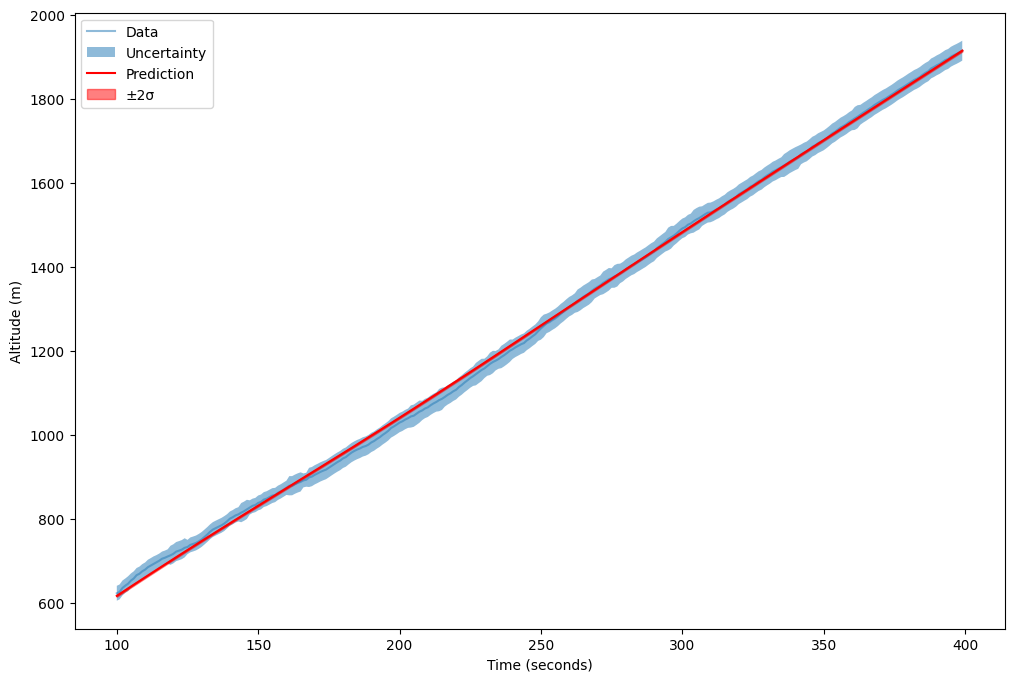

In [23]:
from sklearn.linear_model import LinearRegression

# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
kernel = RBF()+ConstantKernel(5)

lin_model = LinearRegression()
lin_model.fit(seconds.reshape(-1, 1), alt)
print("coef:", lin_model.coef_, "intercept:", lin_model.intercept_)
alt_trend = lin_model.predict(seconds.reshape(-1, 1))
alt_detrended = alt - alt_trend
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=alt_variance,
    normalize_y=False)
# Fit and plot
gp_model.fit(X, alt_detrended)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")
X_pred = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
alt_detrended_pred, alt_detrended_std = gp_model.predict(X_pred, return_std=True)
alt_pred = alt_detrended_pred + lin_model.predict(X_pred)
alt
# plot detrended result
plt.figure(figsize=(12, 8))
plt.plot(seconds, alt_detrended, label='Data', alpha=0.5)
plt.fill_between(seconds, alt_detrended - alt_uc, alt_detrended + alt_uc, alpha=0.5, label='Uncertainty')
plt.plot(X_pred, alt_detrended_pred, label='Prediction', color='red')
plt.fill_between(X_pred.ravel(), alt_detrended_pred - 2*alt_detrended_std, alt_detrended_pred + 2*alt_detrended_std, alpha=0.5, color='red', label='±2σ')
plt.xlabel('Time (seconds)')
plt.ylabel('Detrended Altitude (m)')
plt.legend()
plt.show()

# plot final result
plt.figure(figsize=(12, 8))
plt.plot(seconds, alt, label='Data', alpha=0.5)
plt.fill_between(seconds, alt - alt_uc, alt + alt_uc, alpha=0.5, label='Uncertainty')
plt.plot(X_pred, alt_pred, label='Prediction', color='red')
plt.fill_between(X_pred.ravel(), alt_pred - 2*alt_detrended_std, alt_pred + 2*alt_detrended_std, alpha=0.5, color='red', label='±2σ')
plt.xlabel('Time (seconds)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.show()

# GPyTorch

In [3]:
import torch
import gpytorch

In [33]:
training_mask = range(0, len(seconds), 2)
test_mask = range(0, len(seconds)-1, 1)
normalized_temp = (temp - np.mean(temp)) / np.sqrt(np.var(temp))
normalized_temp_variance = temp_variance / np.var(temp)
train_seconds = torch.tensor(seconds[training_mask], dtype=torch.float32)
train_temp = torch.tensor(normalized_temp[training_mask], dtype=torch.float32)
train_variance = torch.tensor(normalized_temp_variance[training_mask], dtype=torch.float32)
train_temp_uc = torch.tensor(temp_uc[training_mask], dtype=torch.float32)
test_seconds = torch.tensor(seconds[test_mask], dtype=torch.float32)
test_temp = torch.tensor(normalized_temp[test_mask], dtype=torch.float32)
test_variance = torch.tensor(normalized_temp_variance[test_mask], dtype=torch.float32)
test_temp_uc = torch.tensor(temp_uc[test_mask], dtype=torch.float32)

In [34]:
# We will use the simplest form of GP model, exact inference
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_seconds, train_temp, likelihood)

In [35]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_seconds)
    # Calc loss and backprop gradients
    loss = -mll(output, train_temp)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.439   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.429   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.412   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 1.398   lengthscale: 0.852   noise: 0.555
Iter 5/50 - Loss: 1.384   lengthscale: 0.910   noise: 0.515
Iter 6/50 - Loss: 1.367   lengthscale: 0.969   noise: 0.477
Iter 7/50 - Loss: 1.348   lengthscale: 1.031   noise: 0.442
Iter 8/50 - Loss: 1.329   lengthscale: 1.097   noise: 0.409
Iter 9/50 - Loss: 1.307   lengthscale: 1.165   noise: 0.378
Iter 10/50 - Loss: 1.281   lengthscale: 1.236   noise: 0.348
Iter 11/50 - Loss: 1.251   lengthscale: 1.310   noise: 0.320
Iter 12/50 - Loss: 1.218   lengthscale: 1.387   noise: 0.294
Iter 13/50 - Loss: 1.183   lengthscale: 1.467   noise: 0.269
Iter 14/50 - Loss: 1.146   lengthscale: 1.549   noise: 0.245
Iter 15/50 - Loss: 1.108   lengthscale: 1.634   noise: 0.223
Iter 16/50 - Loss: 1.068   lengthscale: 1.722   noise: 0.202
Iter 17/50 - Loss: 1.027   length

In [36]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
observed_pred = likelihood(model(test_seconds))

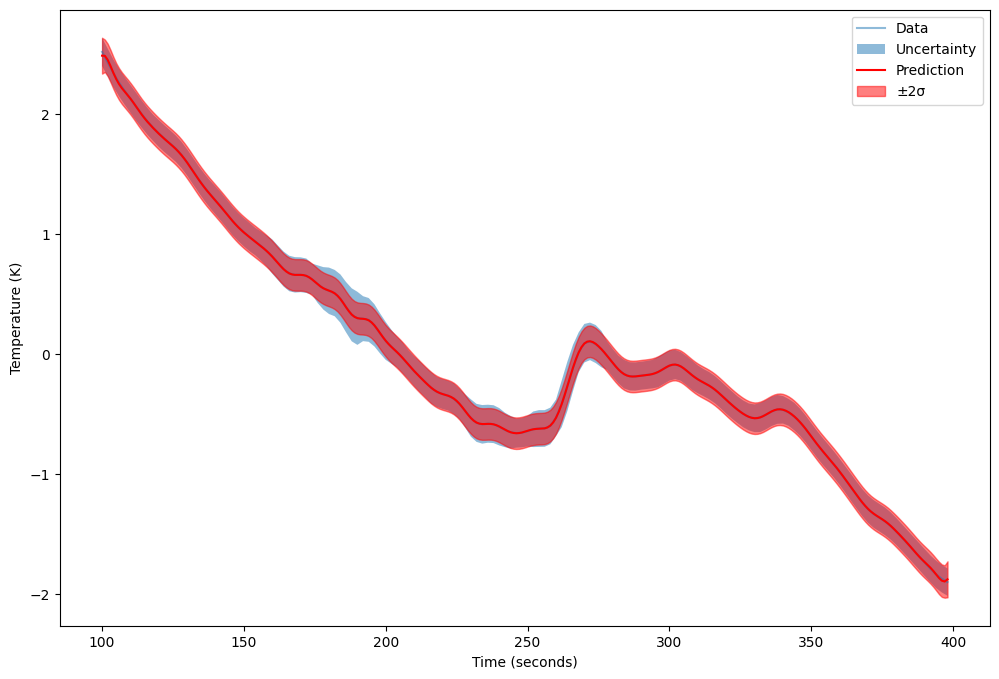

In [37]:
# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_seconds.numpy(), train_temp.numpy(), label='Data', alpha=0.5)
plt.fill_between(train_seconds.numpy(), train_temp.numpy() - train_temp_uc.numpy(), train_temp.numpy() + train_temp_uc.numpy(), alpha=0.5, label='Uncertainty')

# Plot prediction
plt.plot(test_seconds.numpy(), observed_pred.mean.detach().numpy(), label='Prediction', color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(test_seconds.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5, color='red', label='±2σ')

# Sample 3 simulations from the GP
#y_samples = model.sample_y(test_seconds, n_samples=3, random_state=42)
# Plot simulations
#for i in range(3):
#    plt.plot(test_seconds.numpy(), y_samples[:, i], alpha=0.7, label=f'Simulation {i+1}')

plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()